In [1]:
from io import open
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import os, string, random, time, math 
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from IPython.display import clear_output
import re
import string
import mlflow
import mlflow.pytorch

In [2]:
print(torch.cuda.is_available())

True


In [3]:
print(torch.__version__)

2.0.0+cu117


In [4]:
print(device_gpu)

cuda:0


In [5]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

1
NVIDIA GeForce MX550


# **Encoding**

In [6]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad = '-PAD-'
engdic = {pad : 0}
for index ,alpha in enumerate(eng_alphabets):
  engdic[alpha] = index+1
print(engdic)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [7]:
#Telugu unicode for hex range is 3072:3199
tel_alphabets = [chr(alpha) for alpha in range(3072,3199)]
tel_alphabets.append(chr(8204))
tel_alphabets.append(chr(8205))
tel_size = len(tel_alphabets)
teldic = {pad : 0}
for index ,alpha in enumerate(tel_alphabets):
  teldic[alpha] = index+1
print(teldic)  


{'-PAD-': 0, 'ఀ': 1, 'ఁ': 2, 'ం': 3, 'ః': 4, 'ఄ': 5, 'అ': 6, 'ఆ': 7, 'ఇ': 8, 'ఈ': 9, 'ఉ': 10, 'ఊ': 11, 'ఋ': 12, 'ఌ': 13, '\u0c0d': 14, 'ఎ': 15, 'ఏ': 16, 'ఐ': 17, '\u0c11': 18, 'ఒ': 19, 'ఓ': 20, 'ఔ': 21, 'క': 22, 'ఖ': 23, 'గ': 24, 'ఘ': 25, 'ఙ': 26, 'చ': 27, 'ఛ': 28, 'జ': 29, 'ఝ': 30, 'ఞ': 31, 'ట': 32, 'ఠ': 33, 'డ': 34, 'ఢ': 35, 'ణ': 36, 'త': 37, 'థ': 38, 'ద': 39, 'ధ': 40, 'న': 41, '\u0c29': 42, 'ప': 43, 'ఫ': 44, 'బ': 45, 'భ': 46, 'మ': 47, 'య': 48, 'ర': 49, 'ఱ': 50, 'ల': 51, 'ళ': 52, 'ఴ': 53, 'వ': 54, 'శ': 55, 'ష': 56, 'స': 57, 'హ': 58, '\u0c3a': 59, '\u0c3b': 60, '\u0c3c': 61, 'ఽ': 62, 'ా': 63, 'ి': 64, 'ీ': 65, 'ు': 66, 'ూ': 67, 'ృ': 68, 'ౄ': 69, '\u0c45': 70, 'ె': 71, 'ే': 72, 'ై': 73, '\u0c49': 74, 'ొ': 75, 'ో': 76, 'ౌ': 77, '్': 78, '\u0c4e': 79, '\u0c4f': 80, '\u0c50': 81, '\u0c51': 82, '\u0c52': 83, '\u0c53': 84, '\u0c54': 85, 'ౕ': 86, 'ౖ': 87, '\u0c57': 88, 'ౘ': 89, 'ౙ': 90, 'ౚ': 91, '\u0c5b': 92, '\u0c5c': 93, '\u0c5d': 94, '\u0c5e': 95, '\u0c5f': 96, 'ౠ': 97, 'ౡ': 98, 'ౢ': 99, 

In [8]:
print(tel_alphabets[6]+tel_alphabets[2])

ఆం


# **Preprocessing**

In [9]:
X=[]
Y=[]
with open(r"v1.en_tel_wiki_titles.txt",encoding = "utf8") as f:
  for line in f:
    line = line.split()
    eng = line[0].strip().upper()
    tel = line[1].strip()
    X.append(eng)
    Y.append(tel)

In [10]:
def seto(instring):
    for i in range(0, len(instring)-2):
        if (instring[i] == instring[i+1]):
            return 1
        else: 
            continue
    return 0
        

In [15]:
print(seto(L[1]))

0


In [14]:
L=[]
M=[]
with open(r"telugu2.txt",encoding = "utf8") as k:
    for line in k:
        line = line.split()
        EN = line[1].strip().upper()
        TE = line[0].strip()
        if(len(TE)>10 and seto(EN)==0):
            L.append(EN)
            M.append(TE)

In [16]:
X = X+L
Y = Y+M

In [17]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [113]:
for i in range(3):
  print(X_train[i],Y_train[i])

TAJIKISTAN తజికిస్తాన్
BIKKAVOLU బిక్కవోలు
PARATHYROID పారాథైరాయిడ్


In [114]:
print(len(X))

16026


# **Dataset loading**

In [115]:
from torch.utils.data import Dataset

class Dataloader(Dataset):
  def __init__(self, a ,b):
    self.tel_words, self.eng_words = a,b
    self.shuffle_indices  = list(range(len(self.tel_words)))
    random.shuffle(self.shuffle_indices)
    self.shuffle_start_index = 0
  def __len__(self):
    return len(self.tel_words)

  def __getitem__(self, idx):
    return self.tel_words[idx], self.eng_words[idx]

  def get_random_sample(self):
    return self.getitem__(np.random.randint(len(self.tel_words)))

  def get_batch_from_array(self, batch_size, array):
    end = self.shuffle_start_index + batch_size
    batch = []
    if end >= len(self.tel_words):
      batch = [array[i] for i in self.shuffle_indices[0:end%len(self.tel_words)]]
      end = len(self.tel_words)
    return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
  
  def get_batch(self, batch_size, postprocess=True):
    tel_batch = self.get_batch_from_array(batch_size, self.tel_words)
    eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
    self.shuffle_start_index += batch_size +1

    if  self.shuffle_start_index >= len(self.tel_words):
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_index = 0

    return tel_batch , eng_batch


   

In [116]:
train_data = Dataloader(Y_train, X_train)
test_data = Dataloader(Y_test, X_test)
for i in range(3):
    print(test_data[i])

('చంద్రచటర్జీ', 'CHANDRACHATARJEE')
('నెలలు', 'NELALU')
('ట్రూప్', 'TROUPE')


In [117]:
def word_rep(word, dic, device = 'cpu'):
  word_rep = torch.zeros(len(word)+1, 1, len(dic)).to(device)
  for letter_index , letter in enumerate(word):
    pos = dic[letter]
    word_rep[letter_index][0][pos] = 1
  pad_pos = dic[pad]
  word_rep[letter_index+1][0][pad_pos] = 1
  return word_rep  

In [118]:
def gt_rep(word, dic, device = 'cpu'):
  word = word.upper()
  rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
  for letter_index, letter in enumerate(word):
    pos = dic[letter]
    rep[letter_index][0] = pos
  rep[letter_index+1][0] = dic[pad]
  return rep

In [119]:
for i in range(3):
    print(Y[i])

పంజాబీ
దేవత
బెషెవిస్


In [120]:
c=0
for i in X:
  c=c+1
  try:
    a = gt_rep(i,engdic)
  except:
    print(c)

In [19]:
sample2 = gt_rep(X[0],engdic)
print(sample2)

tensor([[16],
        [21],
        [14],
        [10],
        [ 1],
        [ 2],
        [ 9],
        [ 0]])


# **Network Architecture(using GRUs) with Attention**

In [20]:
Max = 30
class Transliteration_Encoder_Decoder(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(Transliteration_Encoder_Decoder,self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)

    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

    self.U = nn.Linear(self.hidden_size,self.hidden_size)
    self.W = nn.Linear(self.hidden_size,self.hidden_size)
    self.attn = nn.Linear(self.hidden_size, 1)
    self.out2hidden = nn.Linear(self.output_size, self.hidden_size)


  def forward(self, input_, max_char = Max, device = 'cpu', gt=None):
    # encoder
    eout, hidden = self.encoder_rnn_cell(input_)
    eout = eout.view(-1,self.hidden_size)
    # decoder
    decoder_state = hidden
    decoder_input = torch.zeros(1, 1, self.output_size).to(device)
   
    outputs = []
    U = self.U(eout)

    for i in range(max_char):

      W = self.W(decoder_state.view(1,-1).repeat(eout.shape[0], 1))
      V = self.attn(torch.tanh(U + W))
      attn_weights = F.softmax(V.view(1,-1), dim = 1)

      attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                               eout.unsqueeze(0))

      embedding = self.out2hidden(decoder_input)
      decoder_input = torch.cat((embedding[0], attn_applied[0]),1).unsqueeze(0)

      out , decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
      
      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1,-1))

      #giving output of one nn to next nn

      idx= torch.argmax(out,2,keepdim=True)
      if not gt is None:
        idx = gt[i].reshape(1,1,1)
      one_hot = torch.zeros(out.shape, device = device)
      one_hot.scatter_(2,idx,1)

      decoder_input = one_hot.detach()
    return outputs

In [21]:
def infer(net, name,n, device):
  net.eval().to(device)
  name_ohe = word_rep(name,teldic,device)
  output = net(name_ohe,n,device)
  return output

In [22]:
model2 = torch.load("model1.pt",map_location = torch.device("cpu"))

In [23]:
out = infer(model2 , "తస్కత్సం",20,device_gpu)

In [25]:
pytorch_total_params = sum(p.numel() for p in model2.parameters())
print(pytorch_total_params)

1035292


In [26]:
for i in range(len(out)):
  print(out[i].shape, list(engdic.keys())[list(engdic.values()).index(torch.argmax(out[i]))])

torch.Size([1, 27]) T
torch.Size([1, 27]) A
torch.Size([1, 27]) S
torch.Size([1, 27]) K
torch.Size([1, 27]) A
torch.Size([1, 27]) T
torch.Size([1, 27]) S
torch.Size([1, 27]) A
torch.Size([1, 27]) M
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-


# **Training**

In [27]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacherforce = False):
  
  net.train().to(device)
  opt.zero_grad()
  tel_batch, eng_batch = train_data.get_batch(batch_size)

  total_loss = 0
  for i in range(batch_size):
    input = word_rep(tel_batch[i], teldic, device)
    gt = gt_rep(eng_batch[i], engdic, device)
    outputs = net(input, gt.shape[0], device, gt = gt if teacherforce else None)

    for index, output in enumerate(outputs):
      loss = criterion(output, gt[index]) / batch_size
      loss.backward(retain_graph = True)
      total_loss += loss
  opt.step()
  return total_loss/batch_size    



In [28]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, display_freq = 5, device = 'cpu'):

  net = net.to(device)
  criterion = nn.NLLLoss(ignore_index = -1)
  opt = optim.Adam(net.parameters(), lr=lr)
  teacher_force_upto = n_batches//3

  loss_arr = np.zeros(n_batches+1)

  for i in range(n_batches):
    loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacherforce = i<teacher_force_upto)) /(i+1)
    if i%display_freq == display_freq-1:
        clear_output(wait=True)
        print('Iteration', i, 'Loss', loss_arr[i])
        plt.figure()
        plt.plot(loss_arr[1:i], '-*')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('\n\n')
        mlflow.log_metric("train_loss",loss_arr[i])
        mlflow.log_metric("Iteration",i)
  return loss_arr

Iteration 1999 Loss 0.110249362885952


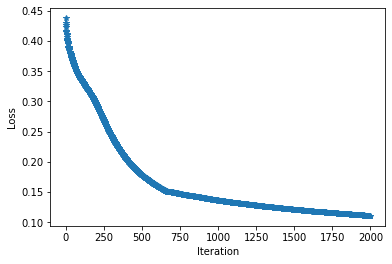

array([0.        , 0.42652631, 0.43753999, ..., 0.11027178, 0.11024936,
       0.11022153])

In [22]:
net = Transliteration_Encoder_Decoder(len(teldic),256,len(engdic))
train_setup(net, lr=args.lr, n_batches = args.n_batches, batch_size = args.batch_size, display_freq=10, device= device_gpu)

In [29]:
def calc_accuracy(net, device = 'cpu'):
  net = net.eval().to(device)
  predictions = []
  accuracy = 0
  for i in range(len(test_data)):
    tel, eng = test_data[i]
    gt = gt_rep(eng, engdic, device)
    outputs = infer(net, tel,gt.shape[0], device)
    correct = 0
    for index,out in enumerate(outputs):
      val, indices = out.topk(1)
      eng_pos = indices.tolist()[0]
      if eng_pos[0] == gt[index][0]:
        correct += 1
    accuracy += correct/gt.shape[0]
  accuracy /= len(test_data)
  accuracy = accuracy*100
  mlflow.log_metric('test_accuracy',accuracy)
  print(accuracy)

# **Hyperparameter Tuning**

In [31]:
class Params(object):
    def __init__(self,batch_size,n_batches,lr,log_interval):
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.lr = lr
        self.log_interval = log_interval   

In [32]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [129]:
del model

Iteration 1999 Loss 0.12839582562446594


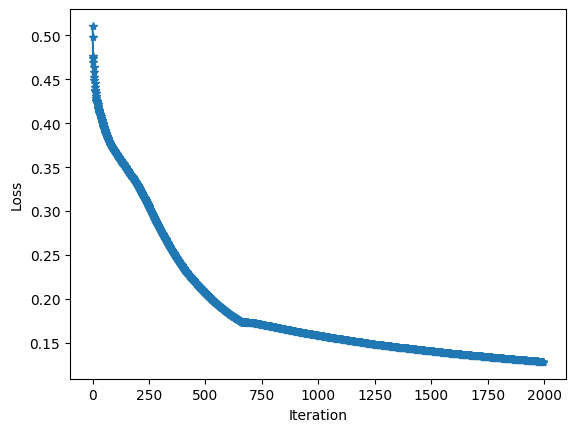

2023/04/04 05:57:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


76.07968262631543


2023/04/04 05:57:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [130]:
for lr in [0.001]:
    for batch_size in [32,64]:
        for n_batches in [1000,1500,2000]:
            expt_id = '%d_%d_%d' % (int(lr*100),n_batches,batch_size)
            
            model = Transliteration_Encoder_Decoder(len(teldic),256,len(engdic))
            args = Params(n_batches,batch_size,lr,10) 
            with mlflow.start_run() as run:
                for key,value in vars(args).items():
                    mlflow.log_param(key,value)
                train_setup(model, lr, n_batches, batch_size, display_freq=10,device= device_gpu)
                calc_accuracy(model,device_gpu)
                mlflow.pytorch.log_model(model,"models")
                del model
                torch.cuda.empty_cache()
            
            

In [128]:
mlflow.end_run()

In [113]:
a="మరియు నూతన సంవత్సర శుభాకాంక్షలు"
words=a.split()
print(words)
s=""
for word in words:
  out2 = infer(net,word,10,device_gpu)
  for i in range(len(out2)):
    k=(list(engdic.keys())[list(engdic.values()).index(torch.argmax(out2[i]))])
    if(str(k)=="-PAD-"):
      continue
    s=s+str(k)
  s=s+" "
print(s)

['మరియు', 'నూతన', 'సంవత్సర', 'శుభాకాంక్షలు']
IYYYBYBYBY YYBYBYBYBY YYBYBBCIYY IYYYYYYYYY 


In [64]:
a="తెలుగు అనేది ద్రావిడ భాషల కుటుంబానికి చెందిన భాష. దీనిని మాట్లాడే ప్రజలు ప్రధానంగా ఆంధ్ర, తెలంగాణాలో ఉన్నారు. ఇది ఆ రాష్ట్రాలలో అధికార భాష. భారతదేశంలో ఒకటి కంటే ఎక్కువ రాష్ట్రాల్లో ప్రాథమిక అధికారిక భాషా హోదా కలిగిన కొద్ది భాషలలో హిందీ, బెంగాలీలతో పాటు ఇది కూడా ఉంది.[5][6] పుదుచ్చేరిలోని యానం జిల్లాలో తెలుగు అధికారిక భాష. ఒడిశా, కర్ణాటక, తమిళనాడు, కేరళ, పంజాబ్, ఛత్తీస్‌గఢ్, మహారాష్ట్ర, అండమాన్ నికోబార్ దీవులలో గుర్తింపబడిన అల్పసంఖ్యాక భాష. దేశ ప్రభుత్వం భారతదేశ ప్రాచీన భాషగా గుర్తించిన ఆరు భాషలలో ఇది ఒకటి.[7][8]భారతదేశంలో అత్యధికంగా మాతృభాషగా మాట్లాడే భాషలలో తెలుగు నాలుగో స్థానంలో ఉంది. భారతదేశంలో 2011 జనాభా లెక్కల ప్రకారం దాదాపు 82 మిలియన్ల మంది మాట్లాడేవారున్నారు.[9] ప్రపంచవ్యాప్తంగా మాతృభాషగా మాట్లాడే భాషల ఎథ్నోలాగ్ జాబితాలో 15 వ స్థానంలో ఉంది.[10][11] ఇది ద్రావిడ భాషా కుటుంబంలో ఎక్కువమంది మాట్లాడే భాష. భారతదేశంలో ఇరవై రెండు షెడ్యూల్ భాషలలో ఇది ఒకటి.[12] ఇది అమెరికాలో వేగంగా అభివృద్ధి చెందుతున్న భాష.[13] తెలుగు భాషలో సుమారు 10,000 పురాతన శాసనాలు ఉన్నాయి.[14] కన్నడిగుడైన శ్రీకృష్ణదేవరాయలు తెలుగు భాషను 'దేశ భాషలందు తెలుగు లెస్స' అని వ్యవహరించాడు. కన్నడ, తెలుగు అక్షరమాలలు చాలా వరకు పోలికగలిగి వుంటాయి."
words=a.split()
print(words)

['తెలుగు', 'అనేది', 'ద్రావిడ', 'భాషల', 'కుటుంబానికి', 'చెందిన', 'భాష.', 'దీనిని', 'మాట్లాడే', 'ప్రజలు', 'ప్రధానంగా', 'ఆంధ్ర,', 'తెలంగాణాలో', 'ఉన్నారు.', 'ఇది', 'ఆ', 'రాష్ట్రాలలో', 'అధికార', 'భాష.', 'భారతదేశంలో', 'ఒకటి', 'కంటే', 'ఎక్కువ', 'రాష్ట్రాల్లో', 'ప్రాథమిక', 'అధికారిక', 'భాషా', 'హోదా', 'కలిగిన', 'కొద్ది', 'భాషలలో', 'హిందీ,', 'బెంగాలీలతో', 'పాటు', 'ఇది', 'కూడా', 'ఉంది.[5][6]', 'పుదుచ్చేరిలోని', 'యానం', 'జిల్లాలో', 'తెలుగు', 'అధికారిక', 'భాష.', 'ఒడిశా,', 'కర్ణాటక,', 'తమిళనాడు,', 'కేరళ,', 'పంజాబ్,', 'ఛత్తీస్\u200cగఢ్,', 'మహారాష్ట్ర,', 'అండమాన్', 'నికోబార్', 'దీవులలో', 'గుర్తింపబడిన', 'అల్పసంఖ్యాక', 'భాష.', 'దేశ', 'ప్రభుత్వం', 'భారతదేశ', 'ప్రాచీన', 'భాషగా', 'గుర్తించిన', 'ఆరు', 'భాషలలో', 'ఇది', 'ఒకటి.[7][8]భారతదేశంలో', 'అత్యధికంగా', 'మాతృభాషగా', 'మాట్లాడే', 'భాషలలో', 'తెలుగు', 'నాలుగో', 'స్థానంలో', 'ఉంది.', 'భారతదేశంలో', '2011', 'జనాభా', 'లెక్కల', 'ప్రకారం', 'దాదాపు', '82', 'మిలియన్ల', 'మంది', 'మాట్లాడేవారున్నారు.[9]', 'ప్రపంచవ్యాప్తంగా', 'మాతృభాషగా', 'మాట్లాడే', 'భాషల', 'ఎథ్నోలాగ్'

In [18]:
from PIL import Image
import pytesseract
print(pytesseract.image_to_string(Image.open(r"C:\Users\Admin\Downloads\sample images\1.jpeg"),lang = 'tel'))

పోగొట్టుకుంటే
కలిగేటాధను
ముందుగా
ఊహించగలిగేవాడు
పొందడానికి పడే
శ్రమ వలన

కలిగే బాధను
పట్టించుకో డు



In [19]:
im = Image.open(r"C:\Users\Admin\Downloads\sample images\1.jpeg")
im.show()


In [ ]:
import Tkinter as tk
Tk = tk()
Tk.geometry